In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/Label_Analysis.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBoolean.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominal.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinal.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumeric.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 134)
Label(s) Data rows: 13
Boolean(s) Data rows: 13
Ordinal(s) Data rows: 16
Nominal(s) Data rows: 84
Numeric(s) Data rows: 21


### User Function(s):

In [22]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data


# import library
from scipy.stats import chi2_contingency
from itertools import combinations


def pairColsMultiIndependenceCat(data, catCol):
    """
    Hypothesis testing using Chi-square statistic and calculating Cramer's V to 
    build consensus for all the categorical variables. 
    """
    # initialize variables
    results = []
    validCols = [col for col in catCol if col in data.columns]

    # use combinations to get unique pairs of columns
    for col1, col2 in combinations(validCols, 2):
        # create a contingency table
        contingencyTable = pd.crosstab(data[col1], data[col2])
        chi2, p_value, _, _ = chi2_contingency(contingencyTable)
        # total number of observations
        n = contingencyTable.values.sum()
        # get the number of categories in each variable (rows and columns)
        r, k = contingencyTable.shape
        min_dim = min(r-1, k-1)
        
        # handle division by zero
        if n * min_dim == 0:
            cramer_v = np.nan
        else:
            cramer_v = np.sqrt(chi2 / (n * min_dim))
        
        results.append({
            'column1': col1,
            'column2': col2,
            'chi2': chi2,
            'p_value': p_value,
            'cramer_v': cramer_v
        })
    
    return pd.DataFrame(results).sort_values(by='cramer_v', ascending=False)
    
    
    
def testIndependenceCat(data, cat1, cat2, flag=False):
    """
    Hypothesis testing using Ch-square statistic and calculating Cramer's V to 
    build consensus for two categorical variables.
    """
    # create a contingency table
    contingencyTable = pd.crosstab(data[cat1], data[cat2])
    # perform Chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingencyTable)
    
    # total number of observations
    n = contingencyTable.sum().sum()
    # get the number of categories in each variable (rows and columns)
    r, k = contingencyTable.shape
    # calculate Cramer's V
    cramer_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

    # display
    print(f"Test of Independence for Catergorical Variables: {cat1} & {cat2}")
    print(f"Chi-square statistic: {chi2:,.2f}")
    print(f"p-value: {p_value:,.4f}")
    print(f"Cramer's V: {cramer_v:,.4f}")

    if flag:
        return contingencyTable



def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=model.classes_)
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    BalAcc = (Recall + Spec) / 2

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    # Prec = TP / (TP + FP)
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    # F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    AvgPrec = metrics.average_precision_score(y,pred)
        
    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(y, pred, zero_division=0))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, BalAcc, Prec, F1Score, AvgPrec, roc_auc



from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

def kfold_grid(model, parameters, X_train, y_train, nSplit=5, score = 'balanced_accuracy'):
    """
    Ten fold CV Stratified
    """
    # instantiate K-Fold cross-validation takes into account the class distribution
    cv = KFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plotFeatureImportance(model, X, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()


def metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'BalancedAccuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, BalancedAccuracy, RecallSensitivity, F1, AveragePrecision, Precision, Specificity, AUC]

    return data


def metricsClassifier(model, X, y, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X, y, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data 

In [5]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


#### Copy DataFrame

In [6]:
# deep copy
df_copy = df.copy()

In [7]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [8]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 134
Total rows after: 14,856 & columns: 122


In [9]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")
print("\nTotal Length of Features:", len(df_bool) + len(df_ordinal) + len(df_nominal) + len(df_numeric))

Orginal Data file Shape: (14856, 122)
Boolean(s) Data rows: 12
Ordinal(s) Data rows: 16
Nominal(s) Data rows: 75
Numeric(s) Data rows: 19

Total Length of Features: 122


### Encode

In [10]:
# features names to list
boolCol = df_bool.boolean.to_list()
nominalCol = df_nominal.nominal.to_list()
ordinalCol = df_ordinal.ordinal.to_list()
numericCol = df_numeric.numeric.to_list()

In [11]:
df[nominalCol].head()

,HeartProcedureType_CAN,PreviousMalignancy_CAN,SurfaceAntigenHEP_B_DON,LV_EjectionFractionMedthod_DON,ResultHBV_NAT_DON,InfectionTherapyIV_CAN,AtTransplantSurfaceHBVAntibodyTotal_CAN,Antihypertensive_DON,ArginnieManagement_DON,OtherDrugUse_DON,PanelReactiveAntibody_CPRA_CAN,LifeSupport_CAN,SurfaceAntigenHEP_B_CAN,UrinePortein_DON,ChestXray_DON,Diabetes_CAN,CardiacArrest_DON,Transfusion_CAN,Hepatitis_B_CoreAntibody_CAN,PulmCath_DON,DefibrillatorImplant_CAN,CerebrovascularDisease_CAN,EpsteinBarrStatusTransplant_CAN,TransfusionNumber_DON,CigaretteHistory_DON,SynthicAntiDiureticHormone_DON,HeparinManagement_DON,SerostatusStatus_HEP_C_CAN,SteroidsUse_DON,BronchoscopyLeft_DON,PrimaryDiagnosisCode_CAN,Hepatitis_B_CoreAntibody_DON,PreTransplantResultHIV_NAT_CAN,GraftFailed_CAN,InotropicMedication_DON,CocaineUse_DON,Diabetes_DON,Hypertension_DON,Vasodilator_DON,DeathMechanism_DON,BronchoscopyRight_DON,Antibody_HEP_C_DON,PastCocaineUse_DON,WaitListDiagnosisCode_CAN,SerologyAntiCMV_DON,Triiodothyronine_T3_DON,CigaretteUse_CAN,Cancer_DON,TransplantSerostatusHIV_CAN,Biopsy_DON,RiskHIV_DON,BloodGroup_CAN,AntibodyResultHBSAB_DON,ChronicSteroidsUse_CAN,PastOtherDrugUse_DON,ResultHCV_NAT_DON,OtherInfectionSource_DON,Diuretics_DON,Thyroxine_T4_DON,PriorLungSurgery_CAN,MyocardialInfarction_DON,Result_RPR_VDRL_DON,PreTranspantHCV_NAT_CAN,ClinicalInfection_DON,NonHeartBeating_DON,Tatoos_DON,HeavyAlcoholUse_DON,InsulinManagement_DON,CoronaryAngiogram_DON,IntracanialCancer_DON,BloodGroup_DON,DiagnosisType_CAN,PriorCardiacSurgery_CAN,EpsteinBarr_DON,IntropesVasodilators_Used
0,Orthotopic Bicaval,N,Negative,Echo,Negative,N,Negative,N,Y,Y,Low Sensitization,Y,Negative,N,Abnormal,Yes,N,Y,Negative,N,Y,N,Positive,NONE,N,N,Y,Negative,Y,Abnormal,DILATED MYOPATHY,Negative,Unknown,0,N,U,N,N,N,GUNSHOT WOUND,Abnormal,Negative,N,DILATED MYOPATHY,Positive,N,Y,No,Negative,Needle,N,O,Unknown,N,Y,Negative,0,Y,N,N,N,Negative,Unknown,Y,N,Y,N,N,Unknown,N,O,DILATED MYOPATHY,N,Positive,No
1,Orthotopic Traditional,N,Negative,Echo,Negative,Y,Negative,Y,N,U,Some Sensitization,Y,Negative,N,Normal,No,N,N,Negative,N,Y,N,Positive,NONE,N,N,N,Negative,Y,Normal,DILATED MYOPATHY,Negative,Unknown,1,N,N,Y,N,Y,CARDIOVASCULAR,Normal,Negative,Y,DILATED MYOPATHY,Positive,N,N,No,Negative,Needle,N,A,Unknown,N,N,Negative,0,Y,N,N,N,Negative,Unknown,Y,N,Y,N,Y,Normal,N,A1,DILATED MYOPATHY,N,Positive,No
2,Orthotopic Bicaval,N,Negative,Echo,Negative,N,Negative,Y,Y,U,Some Sensitization,Y,Negative,N,Abnormal,No,N,N,Negative,N,Y,N,Positive,1 - 5,N,N,Y,Negative,Y,Normal,DILATED MYOPATHY,Negative,Unknown,0,N,U,N,N,Y,DRUG INTOXICATION,Normal,Negative,N,DILATED MYOPATHY,Positive,N,N,No,Negative,Needle,N,A,Unknown,N,N,Negative,0,Y,N,N,N,Negative,Unknown,Y,N,N,N,Y,Normal,N,O,DILATED MYOPATHY,Y,Unknown,No
3,Orthotopic Bicaval,N,Negative,Echo,Negative,N,Negative,N,N,U,Unknown,Y,Negative,Y,Abnormal,No,N,N,Negative,N,Y,N,Positive,6 - 10,N,N,Y,Negative,Y,Unknown,DILATED MYOPATHY,Negative,Unknown,1,Y,U,N,Y,N,INTRACRANIAL HEMORRHAGE/STROKE,Unknown,Negative,N,DILATED MYOPATHY,Positive,N,Y,No,Negative,Needle,N,A,Negative,N,N,Negative,0,Y,Y,N,N,Negative,Unknown,Y,N,N,N,Y,Normal,N,A,DILATED MYOPATHY,N,Positive,Yes
4,Orthotopic Bicaval,N,Negative,Echo,Negative,N,Negative,Y,Y,U,No Sensitization,Y,Negative,N,Abnormal,No,N,N,Negative,N,N,N,Positive,NONE,N,N,Y,Negative,Y,Unknown,DILATED MYOPATHY,Negative,Unknown,0,N,U,N,N,Y,INTRACRANIAL HEMORRHAGE/STROKE,Unknown,Negative,N,DILATED MYOPATHY,Positive,N,Y,No,Negative,Needle,N,A,Unknown,N,N,Negative,0,Y,Y,N,N,Negative,Unknown,Y,N,N,N,N,Unknown,N,A1,DILATED MYOPATHY,Y,Positive,No


#### Split Testing & Validation & Training

In [12]:
# split test and train
from sklearn.model_selection import train_test_split

def EncodeDummyTrainValTest(data, labelTxt, nominalColumns):

    # remove label column from nominalColumns if it exists
    if labelTxt in nominalColumns:
        # remove label
        nominalColumns.remove(labelTxt)

    # dummy Encoding
    df_encoded = pd.get_dummies(data, columns=nominalColumns, drop_first=True)

    # entire features
    X = df_encoded.drop(labelTxt, axis=1)
    y = df_encoded[labelTxt]
    
    # split the dataset into 80% training and 30% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

In [13]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyTrainValTest(df, 'GraftFailed_CAN', nominalCol)

Training Dependent Shape: (8319, 249) & Label Shape: (8319,)
Validation Dependent Shape: (2080, 249) & Label Shape: (2080,)
Testing Dependent Shape: (4457, 249) & Label Shape: (4457,)


#### Scale DataSet

In [14]:
# import Standard Sclaer library
from sklearn.preprocessing import MinMaxScaler

# initialize scaler
scaler = MinMaxScaler()

# fit train
MinMaxScale = scaler.fit(X_train)

# transform train/val/test
X_train_scale = MinMaxScale.transform(X_train)
X_val_scale = MinMaxScale.transform(X_val)
X_test_scale = MinMaxScale.transform(X_test)

# convert to DataFrame
X_train_scale_df = pd.DataFrame(X_train_scale, columns=X.columns.to_list())
X_val_scale_df = pd.DataFrame(X_val_scale, columns=X.columns.to_list())
X_test_scale_df = pd.DataFrame(X_test_scale, columns=X.columns.to_list())

### Feature Selection

In [15]:
# import libraries
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# remove constant features
constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
X_train_scaled = constanFilter.fit_transform(X_train_scale_df)

# update feature names after removing constant features
remaining_feature_names = X_train_scale_df.columns[constanFilter.get_support(indices=True)]

# Step 3: Apply SelectKBest with F-classif
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_train_scaled, y_train)

# Update feature names to reflect remaining, selected features
selected = [remaining_feature_names[i] for i in selector.get_support(indices=True)]

# Step 4: Create a DataFrame with selected features and their F-scores
feature_scores = selector.scores_
feature_scores_df = pd.DataFrame({
    'Feature': remaining_feature_names,
    'F-Score': feature_scores
}).sort_values(by='F-Score', ascending=False)

# display top 20 features by F-Score
feature_scores_df[feature_scores_df['Feature'].isin(selected)].head(20)

,Feature,F-Score
240,PriorCardiacSurgery_CAN_Y,35.271477
5,Ventilator_CAN,30.582714
84,Diabetes_CAN_Yes,29.382983
233,DiagnosisType_CAN_HEART RE-TX/GF,20.180485
88,Transfusion_CAN_Y,16.537207
187,AntibodyResultHBSAB_DON_Unknown,16.288258
207,PreTranspantHCV_NAT_CAN_Unknown,15.143800
8,PreviousTransplantAnyOrgan_CAN,14.190642
118,PrimaryDiagnosisCode_CAN_HEART RE-TX/GF,13.729093
158,WaitListDiagnosisCode_CAN_HEART RE-TX/GF,13.464287


##### F-score Values
The F-score is a measure of statistical significance, representing the variance between groups relative to the variance within groups. Higher scores typically indicate features that can better differentiate between classes in a classification task or explain more variance in a regression task.

- Choosing Feature Thresholds
    - Above 20: Often highly relevant features.
    - 10–20: Moderately important but may still add predictive power.
    - Below 10: These may add noise or are less informa

In [16]:
import re

# Get features
allFeatures = feature_scores_df[feature_scores_df['Feature'].isin(selected)].sort_values(by='F-Score', ascending=False)
features = allFeatures.Feature[(allFeatures.Feature.str.contains('_U')) & (allFeatures['F-Score'] >= 8)]
# features = allFeatures.Feature[(allFeatures.Feature.str.contains('_U'))]

# extract the feature name up to (but not including) '_U'
newFeatures = [re.search(r'^(.*?)_U', feature).group(1) if '_U' in feature else feature for feature in features]

print(newFeatures)

['AntibodyResultHBSAB_DON', 'PreTranspantHCV_NAT_CAN', 'Hepatitis_B_CoreAntibody_CAN', 'PanelReactiveAntibody_CPRA_CAN']


In [17]:
# select features with F-Score >= 10
selectedFeatures = allFeatures['Feature'][allFeatures['F-Score'] >= 10]

In [18]:
print(sorted(selectedFeatures))

['AntibodyResultHBSAB_DON_Unknown', 'BloodGroup_DON_A2B', 'Creatinine_Difference', 'Diabetes_CAN_Yes', 'DiagnosisType_CAN_HEART RE-TX/GF', 'Hepatitis_B_CoreAntibody_CAN_Unknown', 'InotropicMedication_DON_Y', 'MismatchLevel_DR_LOCUS', 'PanelReactiveAntibody_CPRA_CAN_Unknown', 'PreTranspantHCV_NAT_CAN_Unknown', 'PreviousTransplantAnyOrgan_CAN', 'PreviousTransplantNumber_CAN', 'PreviousTransplantSameOrgan_CAN', 'PrimaryDiagnosisCode_CAN_HEART RE-TX/GF', 'PriorCardiacSurgery_CAN_Y', 'TotalBilirubin_Difference', 'TotalDayWaitList_CAN', 'Transfusion_CAN_Y', 'Ventilator_CAN', 'WaitListDiagnosisCode_CAN_HEART RE-TX/GF']


### Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [20]:
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 20, num=3, dtype=np.intc))
# The number of trees in the fores
n_estimators = list(np.linspace(25, 500, num=4, dtype=np.intc))
# maximum number of levels in tree
max_depth = list(np.linspace(2, 11, num=3, dtype=np.intc))
max_depth.append(None)
# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
n_estimators=n_estimators,
criterion = ['gini', 'entropy', 'log_loss'],
# class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'],
class_weight = ['balanced'],
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'n_jobs': -1,'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

In [ ]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10'
Model = 'rfc_one_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_one_fit = kfold_grid(model, parameters, X_train_scale_df[selectedFeatures], y_train, nSplit=10, score = 'balanced_accuracy')

# best model
model = rfc_one_fit.best_estimator_

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.65      0.75      7255
           1       0.16      0.46      0.24      1064

    accuracy                           0.62      8319
   macro avg       0.53      0.55      0.49      8319
weighted avg       0.80      0.62      0.68      8319



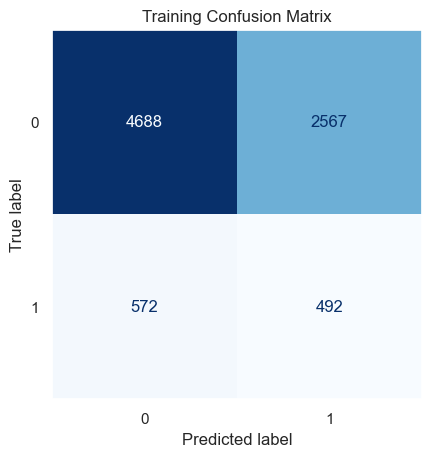

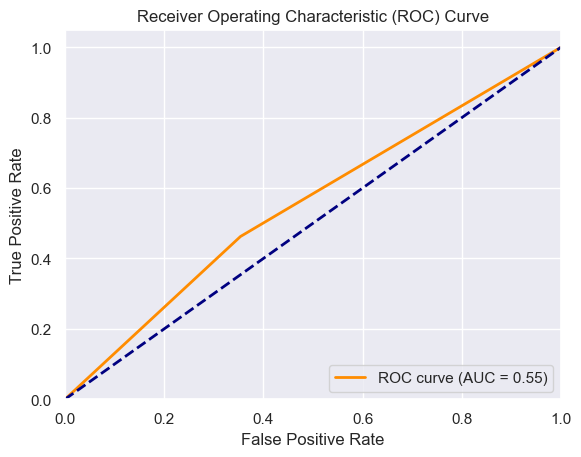

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.14313,0.160837,0.646175,0.554291


In [23]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_scale_df[selectedFeatures], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.65      0.75      1814
           1       0.16      0.45      0.23       266

    accuracy                           0.62      2080
   macro avg       0.52      0.55      0.49      2080
weighted avg       0.80      0.62      0.68      2080



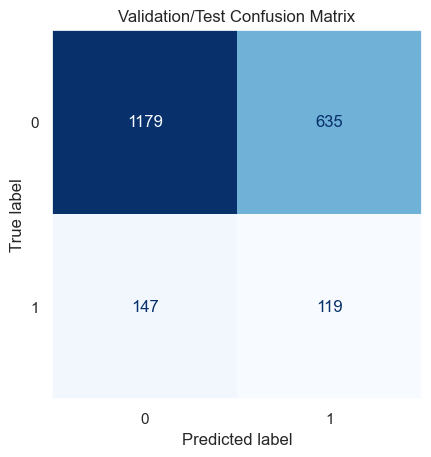

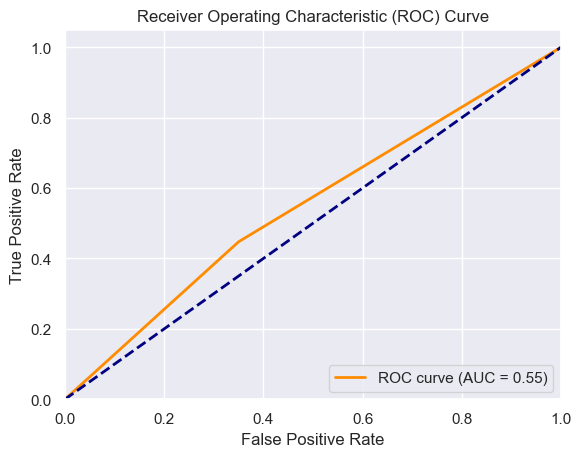

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.143130,0.160837,0.646175,0.554291
1,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.548657,0.447368,0.233333,0.141279,0.157825,0.649945,0.548657


In [24]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_scale_df[selectedFeatures], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

                                                   % Feature Importance
PriorCardiacSurgery_CAN_Y                                         100.0
Diabetes_CAN_Yes                                                    0.0
Transfusion_CAN_Y                                                   0.0
DeathMechanism_DON_DRUG INTOXICATION                                0.0
TotalDayWaitList_CAN                                                0.0
Creatinine_Difference                                               0.0
DiagnosisType_CAN_HEART RE-TX/GF                                    0.0
Hypertension_DON_Y                                                  0.0
PreviousTransplantAnyOrgan_CAN                                      0.0
EducationLevel_CAN                                                  0.0
Ventilator_CAN                                                      0.0
PanelReactiveAntibody_CPRA_CAN_High Sensitization                   0.0


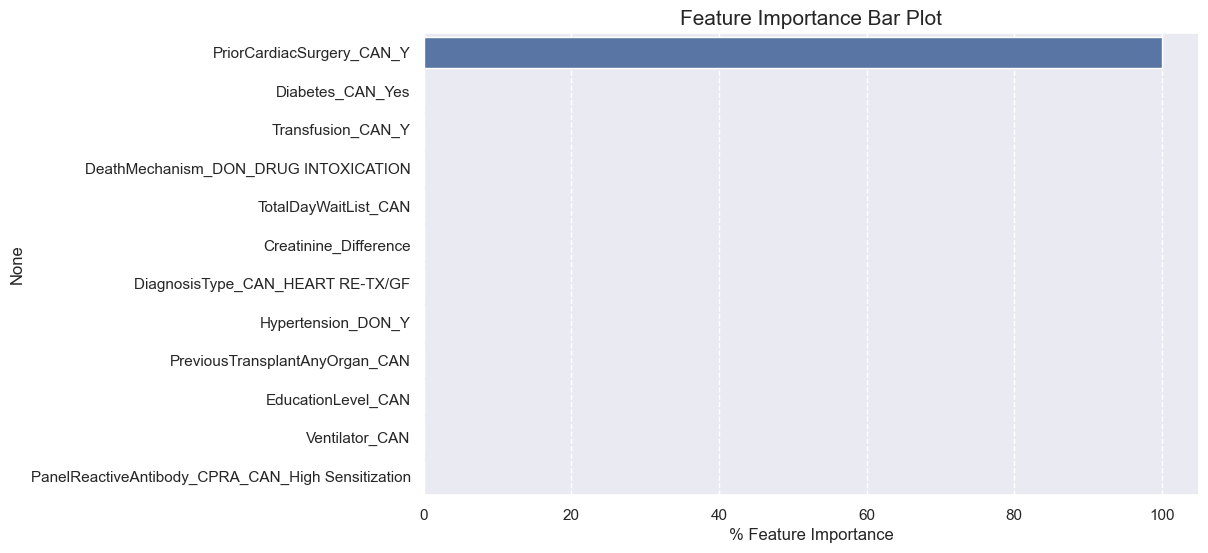

In [25]:
# plot
plotFeatureImportance(model, X_train_scale_df[selectedFeatures],figsize=(10,6))

### Logistic Regression

In [26]:
# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2)),
class_weight = ['balanced']
)

# Base Model
lrc_param = {'max_iter':10000, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

In [27]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10'
Model = 'lrc_one_fit'

# CV with grid search for Hyper-Parameter tuning
lrc_onel_fit = stratified_grid(model, parameters, X_train_scale_df[selectedFeatures], y_train, nSplit=10, score = 'balanced_accuracy')

# best model
model = lrc_onel_fit.best_estimator_

CV accuracy: 0.577 +/- 0.030


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72      7255
           1       0.17      0.56      0.26      1064

    accuracy                           0.60      8319
   macro avg       0.54      0.58      0.49      8319
weighted avg       0.81      0.60      0.67      8319



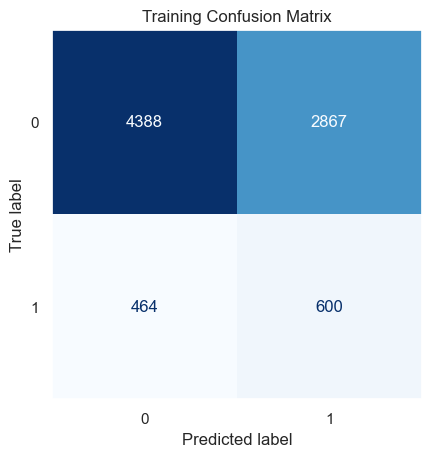

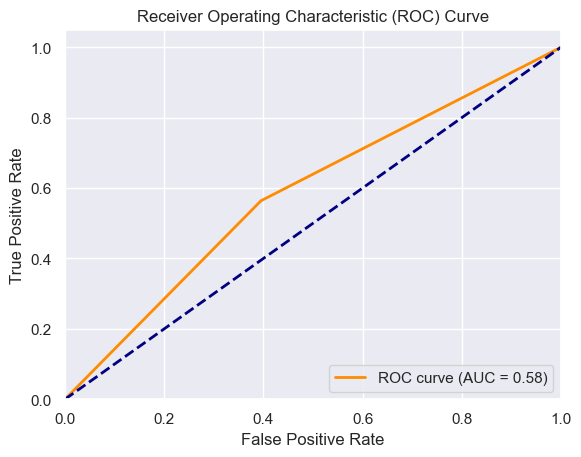

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.143130,0.160837,0.646175,0.554291
1,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.548657,0.447368,0.233333,0.141279,0.157825,0.649945,0.548657
2,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Training,0.584367,0.563910,0.264842,0.153366,0.173060,0.604824,0.584367


In [28]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_scale_df[selectedFeatures], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.61      0.72      1814
           1       0.16      0.50      0.24       266

    accuracy                           0.59      2080
   macro avg       0.52      0.55      0.48      2080
weighted avg       0.80      0.59      0.66      2080



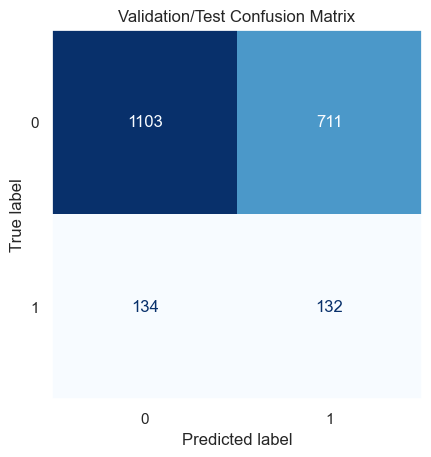

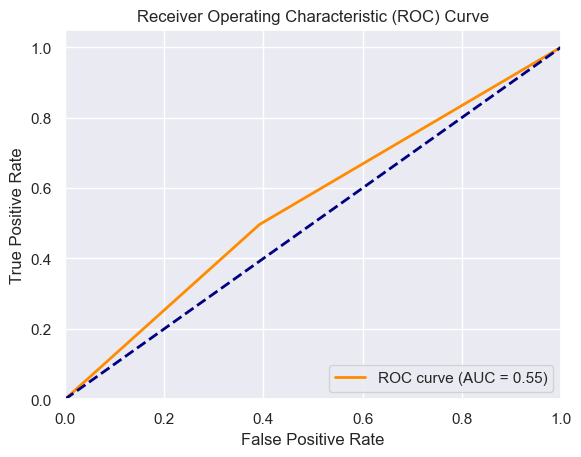

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Training,0.554291,0.462406,0.238661,0.143130,0.160837,0.646175,0.554291
1,RandomForestClassifier,rfc_one_fit,RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.548657,0.447368,0.233333,0.141279,0.157825,0.649945,0.548657
2,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Training,0.584367,0.563910,0.264842,0.153366,0.173060,0.604824,0.584367
3,LogisticRegression,lrc_one_fit,LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10,Validation,0.552145,0.496241,0.238052,0.142126,0.156584,0.608049,0.552145


In [29]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_scale_df[selectedFeatures], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [48]:
# import libraries
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

# remove constant features
constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
X_train_scaled = constanFilter.fit_transform(X_train_scale_df)

# update feature names after removing constant features
remaining_feature_names = X_train_scale_df.columns[constanFilter.get_support(indices=True)]

# Step 3: Apply SelectKBest with F-classif
selector = SelectKBest(score_func=chi2, k=50)
X_new = selector.fit_transform(X_train_scaled, y_train)

# Update feature names to reflect remaining, selected features
selected = [remaining_feature_names[i] for i in selector.get_support(indices=True)]

# Step 4: Create a DataFrame with selected features and their F-scores
feature_scores = selector.scores_
feature_scores_df = pd.DataFrame({
    'Feature': remaining_feature_names,
    'F-Score': feature_scores
}).sort_values(by='F-Score', ascending=False)

# display top 20 features by F-Score
feature_scores_df[feature_scores_df['Feature'].isin(selected)].head(50)

,Feature,F-Score
144,DeathMechanism_DON_ELECTRICAL,2775.628713
180,BloodGroup_CAN_A1B,2772.000000
181,BloodGroup_CAN_A2,2690.889840
235,DiagnosisType_CAN_MUSCULAR DYSTROPHY,1840.872230
149,DeathMechanism_DON_STAB,1678.787931
225,BloodGroup_DON_A2B,1612.328650
57,ResultHBV_NAT_DON_Positive,1444.425560
53,SurfaceAntigenHEP_B_DON_Positive,1426.969259
90,Hepatitis_B_CoreAntibody_CAN_Unknown,1397.592909
54,SurfaceAntigenHEP_B_DON_Unknown,1378.478894
